# Genetic Algorithm Project

This project goes through a genetic algorithm to create the famous alan turing portrait out of random samples. The main code is available first, and then a description is presented.

The class IGA manages the whole process.
There may be multiple approaches for different sections, but the default options provide the most efficient.

#### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools

#### Image Genetic Algorithm class definition

In [2]:
class IGA:
	def __init__(self, target, dimentions, population_size, mutation_count, target_similarity):
		self.img_dims = dimentions
		self.population_size = population_size
		self.mutation_count = mutation_count
		self.target = target
		self.target_similarity = target_similarity
		self.grid = [list(i) for i in itertools.product(range(dimentions), range(dimentions))]

	def fitness(self, img):
		return np.sum(np.abs(img-self.target))

	def similarity(self, img):
		return 100*(1-(self.fitness(img)/np.sum(self.target)))

	def _sigmoid(self):
		return 1/(0.5+np.exp(A))

	def value_probability(self, fits):
		comps = np.array(fits) / np.sum(fits)
		sigs = _sigmoid(comps)
		probs = sigs / np.sum(sigs)
		return probs

	def is_better(self, a, b):
		if a < b:
			return True
		else:
			return False

	def run(self, 
			show_prints=True,
			imshow=True, 
			biased_random_selection=False, 
			binary_co=False):

		population = np.random.randint(0, 255, size=(self.population_size, self.img_dims, self.img_dims))
		similarity_percent = 0
		epoch = 0
		rising, falling = 0, 0
		after_crossover_mean_prev = 1e10
		fits_list, sim_list, muterate_list = [], [], []

		while similarity_percent < self.target_similarity:
			fits = [self.fitness(pop) for pop in population]

			# Selection -----------------------------------------------------------------

			if not biased_random_selection:
				fits_sorted = np.sort(fits)
				selection_population = [population[fits.index(fits_sorted[i])] for i in range(3)]
				selection_population = np.array(selection_population)  # .reshape((self.population_size//2, self.img_dims, self.img_dims))
			else:
				probs = self.value_probability(fits)
				selection = np.random.choice(np.linspace(0, population_size-1, population_size, dtype=int), 
											size = population_size, 
											p = probs)
				selection_population = population[selection]

			# Crossover -----------------------------------------------------------------

			if binary_co:
				crossover_population = []
				for i in range(0, self.population_size, 2):
					child_A = np.zeros((self.img_dims, self.img_dims)).flatten()
					child_B = np.zeros((self.img_dims, self.img_dims)).flatten()
					parent_A = selection_population[i].flatten()
					parent_B = selection_population[i+1].flatten()
					s = np.random.choice(np.linspace(0, len(self.grid)-1, len(self.grid), dtype=int), size=self.img_dims*self.img_dims//2, replace=False)
					sn = list(set(np.linspace(0, len(self.grid)-1, len(self.grid), dtype=int)) - set(s))
					child_A[s] = parent_A[s]
					child_A[sn] = parent_B[sn]
					child_B[s] = parent_B[s]
					child_B[sn] = parent_A[sn]
					crossover_population.append(child_A.reshape((self.img_dims, self.img_dims)))
					crossover_population.append(child_B.reshape((self.img_dims, self.img_dims)))
			else:
				crossover_population = np.zeros((self.population_size, self.img_dims, self.img_dims))
				for v in range(self.population_size):
					for i in range(self.img_dims):
						for j in range(self.img_dims):
							crossover_population[v, i, j] = np.random.choice(selection_population[:, i, j])
			
			after_crossover_fits = [self.fitness(pop) for pop in crossover_population]
			after_crossover_fits_sorted = np.sort(after_crossover_fits)
			after_crossover_mean = np.mean(after_crossover_fits)

			# Mutation -----------------------------------------------------------------

			# adjusting mutation rate
			if self.is_better(after_crossover_mean_prev, after_crossover_mean):
				rising += 1
			if self.is_better(after_crossover_mean, after_crossover_mean_prev):
				falling += 1
			if falling > 20:
				falling = 0
				rising -= 1
			elif rising > 10 and falling < 6:
				self.mutation_count = 0 if self.mutation_count == 1 else self.mutation_count - 1 
				rising = 0
				falling = 0
			if self.mutation_count == 0 and after_crossover_mean_prev == after_crossover_mean:
				self.mutation_count += 2
			after_crossover_mean_prev = after_crossover_mean

			# performing adaptive mutation
			for genimg in crossover_population:
				if self.is_better(self.fitness(genimg), after_crossover_mean):
					continue
				else:
					for i in range(self.mutation_count):
						genimg[np.random.randint(0, self.img_dims), np.random.randint(0, self.img_dims)] = np.random.randint(0, 255)
			
			population = np.array(crossover_population)
			similarity_percent = self.similarity(crossover_population[after_crossover_fits.index(after_crossover_fits_sorted[0])])
            
			fits_list.append(after_crossover_mean)
			sim_list.append(similarity_percent)
			muterate_list.append(self.mutation_count)
            
			if show_prints and epoch % 500 == 0:
				plt.title("Generation: {}, Similarity: {}%, Fitness(mean): {}".format(epoch, round(similarity_percent, 2), round(after_crossover_mean, 1)))
				plt.imshow(crossover_population[0], cmap='gray')
				plt.show()
			
			epoch += 1			

			if imshow:
				cv2.imshow("hc", cv2.resize(population[0].astype(np.uint8), (population[0].shape[1]*4, population[0].shape[0]*4)))
				cv2.waitKey(1)
		print("\nFinal Results:")
		print("Generation: {}\t, Similarity: {}%\t, Fitness(mean): {}".format(epoch, round(similarity_percent, 2), round(after_crossover_mean, 1)))
		plt.title("Generation: {}, Similarity: {}%, Fitness(mean): {}".format(epoch, round(similarity_percent, 2), round(after_crossover_mean, 1)))
		plt.imshow(crossover_population[0], cmap='gray')
		plt.show()
		return crossover_population[0], fits_list, sim_list, muterate_list

#### Run

In [3]:
IMG_DIMS = 32
image = cv2.imread('turing.jpg')   
image = cv2.resize(image, (IMG_DIMS, IMG_DIMS))
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

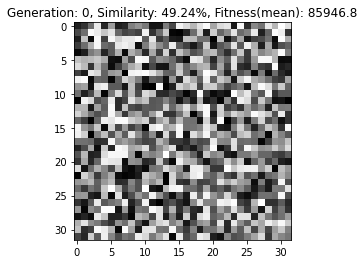

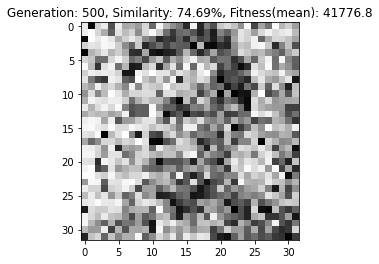

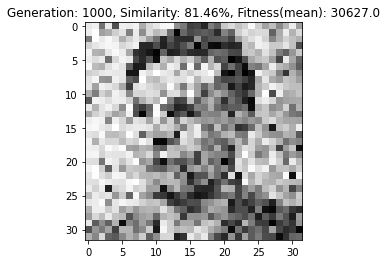

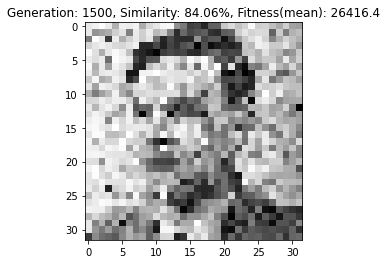

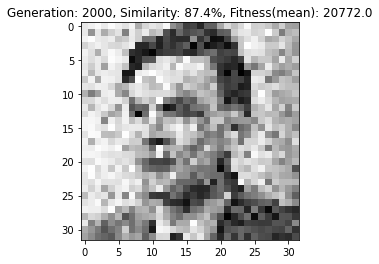

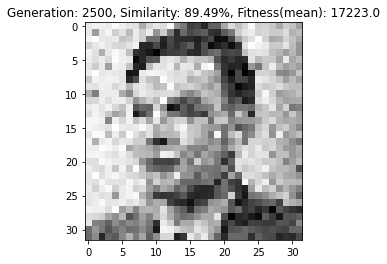

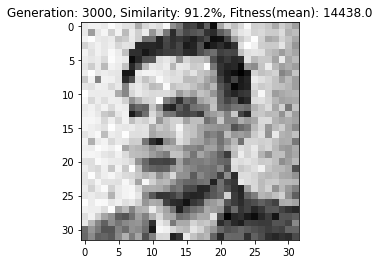

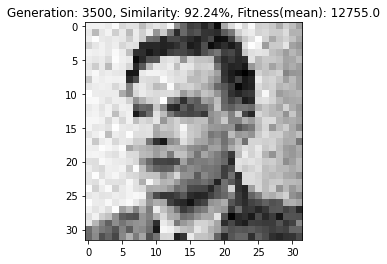

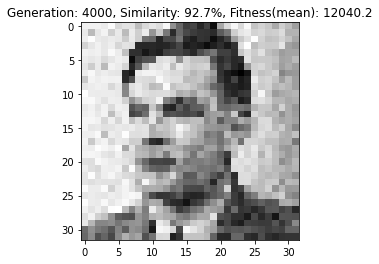

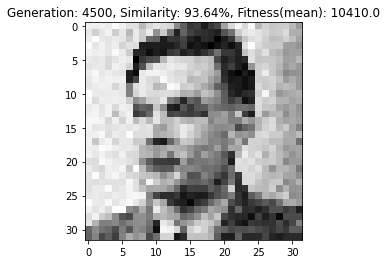

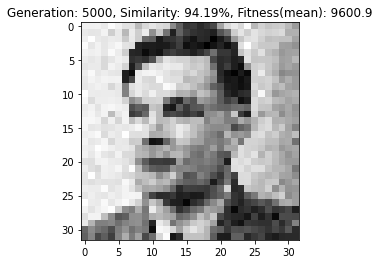

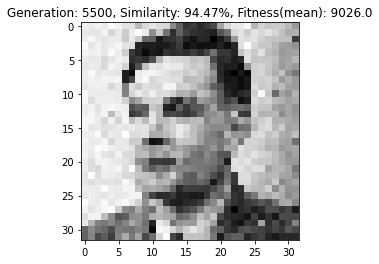

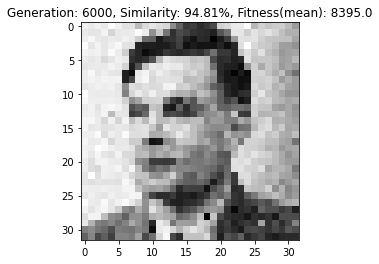


Final Results:
Generation: 6172	, Similarity: 95.01%	, Fitness(mean): 8264.0


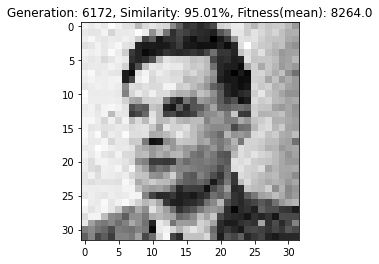

In [4]:
population_size   = 8
mutation_count    = 20
target_similarity = 95

iga = IGA(target=gray_image, 
			dimentions=IMG_DIMS, 
			population_size=population_size, 
			mutation_count=mutation_count, 
			target_similarity=target_similarity) 
result, fits, sims, mutes = iga.run(imshow=False)

Text(0.5, 1.0, 'similarity percentage')

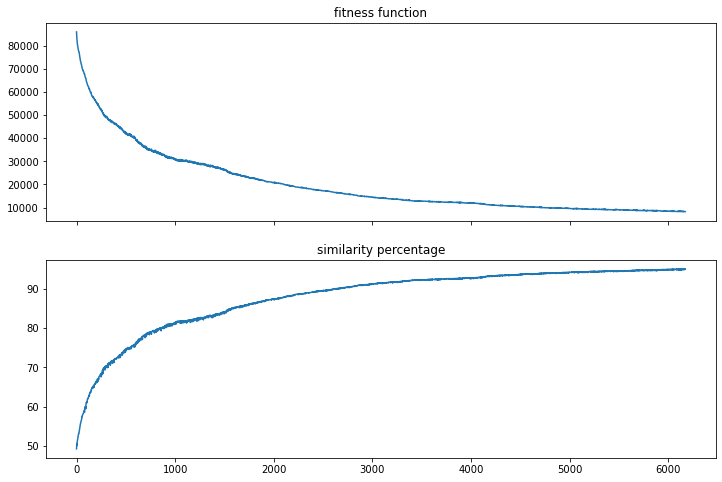

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax1.plot(fits)
ax1.set_title('fitness function')
ax2.plot(sims)
ax2.set_title('similarity percentage')

## Description

Genetic Algorithm is first of all, a repetitive task based on a desired threshold. Here we set our desire to a minimum Similarity Percent (default >90). Each loop consists of 3 main sections and additional computations. 

The 3 main sections include Selection, Crossover, and Mutation; which are detailed later on ...

![alt text](GAOV.png "Title")

### Selection

In the selection part, 2 methods are implemented. The Biased-Random selection chooses chromosomes from the population, based on how good their fitness function is. To do this, the populations fitnesses should be mapped to a probability distribution. The one with lower fitness, get higher probability (a sigmoid function and a Real->Probability mapper are defined in the constructor).

The other method picks 3 chromosomes with the lowest fitnesses, which act as parents for crossover later on. The number 3 is arbitrarily chosen and can be adjusted. 
###### This method (not biased-random) is preferred for the problem, as the Biased-Random method took longer to converge.

### Crossover

This section is also implemented in 2 approaches. The first one, binary crossover -also displayed in the GA overview image above, generates two children from only two parents. Genes are taken 50% from each of the parents.
This method should be handled with care as only even number of parents can be chosen and works with biased-random selection.

The other method generates children from all parents simultaneously. Each pixel in each child is picked randomly from the same pixel position of all the parents.
###### This method is preferred because it yields to better results.

After crossover, the new population is evaluated and a fitness mean is calculated for later.

### Mutation

Mutation involves choosing a random gene from a chromosome and changing it to escape local minima. The original mutation may converge (it did) to a good local minima for 2-D chromosomes (but it still is a "local" minima). self.mutation_count acts as the number of mutations in a sample (and is adjusted, described later). <a href=https://neptune.ai/blog/adaptive-mutation-in-genetic-algorithm-with-python-examples>details</a>

In this project, <a href=https://link.springer.com/article/10.1007%2Fs005000000042>Adaptive Mutation</a> is implemented.

    1-Calculate the average fitness value of the population (f_avg);
    
    2-For each chromosome, calculate its fitness value (f);

    3-If f<f_avg, then this solution is regarded as a low-quality solution and thus the mutation rate should be kept high because this would increase the quality of this solution;

    4-If f>f_avg, then this solution is regarded as a high-quality solution and thus the mutation rate should be kept low to avoid disrupting this high-quality solution;

Also to yield better results more quickly, the mutation rate is adaptive. For lower values of fitness (close to local minima) it is critical to have high mutation rate as it often crosses the global minima and takes more time to converge. The initial mutation rate is arbitrarily chosen (eg 20) and as the training goes on, the rate drops.

There's no absolute equation for this drop; therefore it is implemented as follows.<br>
If the current mean fitness is better (less than) than the previous one, "falling" is incremented, indicating a good iteration. If not, "rising" is incremented, indicating a fallback. <br>
=> if there are a lot of risings and a few fallings (line 8), mutation rate is dropped by one, "falling" and "rising" are restarted.<br>

=> If there's a good sequence of falls in the mean fitnes value (line 5), we restart counting "falling" and decrement "rising" as it has little effect at the time. <br>

If mutation is turned off, the fitness function converges to a flat very quickly and stays there. However, it still gets better (for a while, 2-3 epochs) before standing still. In our algorithm, mutation rate often drops so ...<br>
=> If mutation rate drops to zero, it waits for the model to converge and then mutation rate is spiked up by 1.<br>
This way we benefit from the decrementation of a no-mutation model, besides a model with mutation.

Text(0.5, 1.0, 'adaptive mutation rate')

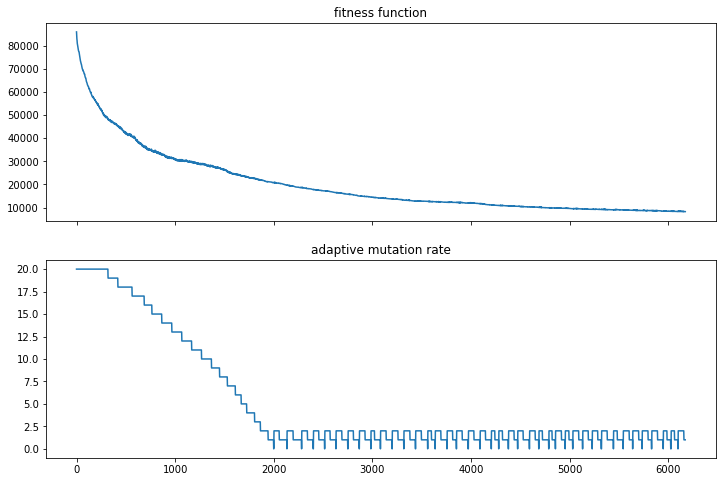

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax1.plot(fits)
ax1.set_title('fitness function')
ax2.plot(mutes)
ax2.set_title('adaptive mutation rate')